In [1]:
import numpy as np
import pandas as pd 
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import seaborn as sns
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import pickle
import sys
import collections

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
## import sys
import lmdb
import h5py
caffe_root = '/work/sagarj/caffe-rc5/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
from collections import defaultdict
import caffe
import cv2

model_root = "/work/sagarj/Work/BellLabs/caffe_models/caffe_model_1/"
#net_weights='caffe_beauty_augmented/caffe_model_beauty_augmented_iter_10000.caffemodel'
net_weights='caffe_model_beauty_4_votes/caffe_model_1_iter_24732.caffemodel'
net_definition='caffenet_deploy_1.prototxt'
mean_file_binaryproto = '../Data/cityAugmentedMean.npy'

#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227
#Size of images
#IMAGE_WIDTH = 224
#IMAGE_HEIGHT = 224
NCHANNELS = 3
meanR = 105.487823486
meanG = 113.741088867
meanB = 116.060394287

meanMat = np.zeros((NCHANNELS,IMAGE_WIDTH,IMAGE_HEIGHT))
meanMat[0,:,:].fill(meanR)
meanMat[1,:,:].fill(meanG)
meanMat[2,:,:].fill(meanB)

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def getScores(imageDict):

    caffe.set_mode_gpu()
    model_def = model_root+net_definition
    model_weights = model_root + net_weights

    net = caffe.Net(model_def,      # defines the structure of the model
                    model_weights,  # contains the trained weights
                    caffe.TEST)     # use test mode (e.g., don't perform dropout)
    
    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    mean = np.load(mean_file_binaryproto)
    print mean.shape
    feats = {}
    for k in imageDict:
        #featArray = predictImage(row['path'] , NN , TFormer)
        imgPath = imageDict[k]['path']
        #print imgPath
        path = imgPath.strip()
        if not os.path.exists(path):
            featArray = np.zeros((1,2))
        else:
            im =  transformer.preprocess('data',caffe.io.load_image(path))
            im = im - mean
            net.blobs['data'].data[...] = im - meanMat
            net.forward()
            featArray = net.blobs['prob'].data.copy()

        feats[k] = featArray
    return feats


In [46]:
ImageDir = "/datasets/sagarj/streetView/LondonImages/GreaterLondon_NoRot/"
LondonPoints = pd.read_csv("/datasets/sagarj/streetView/LondonImages/greater_london_points.csv",header=None)

In [47]:
imageDict = {}
for index , row in LondonPoints.iterrows():
    ID = str(int(row[0])) + '_' + str(int(row[1]))
    if os.path.exists(ImageDir+ID):
        files = os.listdir(ImageDir+ID)
        for f in files:
            comps = f.split('.')
            imageDict[comps[0]] = {}
            imageDict[comps[0]]['path'] =  ImageDir+ID+"/"+f
            imageDict[comps[0]]['rot'] = comps[0].split('_')[-1]
            

In [48]:
beautyScores = getScores(imageDict)

(3, 227, 227)


In [49]:
finalDict = imageDict.copy()

In [50]:
len(beautyScores)

60618

In [51]:
# with open("SVLondonScores.pkl",'wb') as f:
#     pickle.dump(beautyScores,f,protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
for k in imageDict:
    label = np.argmax(beautyScores[k])
    confidence = beautyScores[k][0][label]
    finalDict[k]['label'] = label
    finalDict[k]['confidence'] = confidence
    

In [62]:
finalDict

{'8363123_1077704848_0': {'confidence': 0.5524544,
  'label': 1,
  'path': '/datasets/sagarj/streetView/LondonImages/GreaterLondon_NoRot/8363123_1077704848/8363123_1077704848_0.jpg',
  'rot': '0'},
 '16790097_173736413_0': {'confidence': 0.51746166,
  'label': 0,
  'path': '/datasets/sagarj/streetView/LondonImages/GreaterLondon_NoRot/16790097_173736413/16790097_173736413_0.jpg',
  'rot': '0'},
 '7995502_1564517311_0': {'confidence': 0.52130073,
  'label': 1,
  'path': '/datasets/sagarj/streetView/LondonImages/GreaterLondon_NoRot/7995502_1564517311/7995502_1564517311_0.jpg',
  'rot': '0'},
 '8375945_195712_0': {'confidence': 0.6301471,
  'label': 1,
  'path': '/datasets/sagarj/streetView/LondonImages/GreaterLondon_NoRot/8375945_195712/8375945_195712_0.jpg',
  'rot': '0'},
 '2955913_629000_0': {'confidence': 0.51781267,
  'label': 1,
  'path': '/datasets/sagarj/streetView/LondonImages/GreaterLondon_NoRot/2955913_629000/2955913_629000_0.jpg',
  'rot': '0'},
 '10803762_3939800061_0': {'con

In [54]:
beautyConfidence = []
uglyConfidence = []

for k in finalDict:
    if finalDict[k]['label'] == 1:
        beautyConfidence.append(finalDict[k]['confidence'])
    else:
        uglyConfidence.append(finalDict[k]['confidence'])

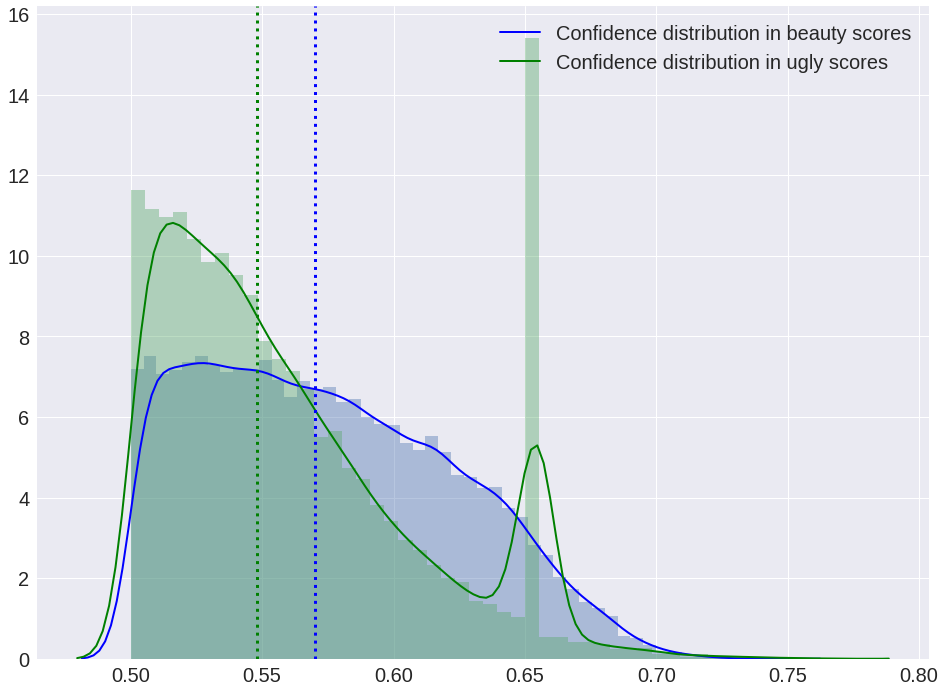

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.distplot(beautyConfidence,kde_kws={"color": "b", "lw": 2, "label": "Confidence distribution in beauty scores"})
sns.distplot(uglyConfidence,kde_kws={"color": "g", "lw": 2, "label": "Confidence distribution in ugly scores"})
ax.axvline(x=np.median(beautyConfidence), ymin=0, ymax=1, linewidth=3, color = 'b', linestyle='dotted')
ax.axvline(x=np.median(uglyConfidence), ymin=0, ymax=1, linewidth=3, color = 'g', linestyle='dotted')

In [56]:
# import csv
# with open('londonSV.csv', 'wb') as csvfile:
#     csvWriter = csv.writer(csvfile, delimiter=',')
#     csvWriter.writerow(['WayID','PointID','Rotation','BeautyLabel','Confidence'])
#     for k in finalDict:
#         ids = k.split("_")
#         row = [ids[0] , ids[1],ids[2] , finalDict[k]['label'] , finalDict[k]['confidence']]
#         csvWriter.writerow(row)
        

In [57]:
import os
import glob
import random
import numpy as np
import pickle

import cv2
import sys
caffe_root = '/work/sagarj/caffe-rc5/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
from caffe.proto import caffe_pb2
import lmdb

#Size of images
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def make_datum(img, label):
    #image is numpy.ndarray format. BGR instead of RGB
    return caffe_pb2.Datum(
        channels=3,
        width=IMAGE_WIDTH,
        height=IMAGE_HEIGHT,
        label=label,
        data=np.rollaxis(img, 2).tostring())

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)


In [61]:
train_lmdb = '../Data/London_Images_lmdb'
log = "lmdblogs.log"

In [66]:
# in_db = lmdb.open(train_lmdb, map_size=int(1e12))
# f = open(log,'w')
# with in_db.begin(write=True) as in_txn:
#     for in_idx, (k, v) in enumerate(finalDict.items()):
#         img_path = finalDict[k]['path']
#         label = finalDict[k]['label']
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#         img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
#         datum = make_datum(img, label)
#         in_txn.put('{:0>5d}'.format(in_idx), datum.SerializeToString())
#         line = '{:0>5d}'.format(in_idx) + ':' + img_path + "\n"
#         f.write(line)
# in_db.close()